# Hyperparameters in a QML circuit
The problem we consider is the Variational Quantum Linear Solver (VQLS) which aims to train a quantum circuit to look for solutions of the equation $$Ax = b$$
where $A$ is a $2^n\times 2^n$ matrix, and $x, b$ are $2^n$ vectors.

To do so we use the simplified model: 
$$\begin{align*}
b &= U|0\rangle\\
x &= V(\vec{w})|0\rangle\\
A &= \sum_{i=1}^n c_iA_i\\
\end{align*}$$

where all the $A_i$'s are unitaries, and $V(\vec{w})$ is a variational block with $\vec{w}$ consisting of our trainable weights.


In [1]:
%matplotlib inline
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## The optimizer parameters

In [2]:
steps = 20  # Number of optimization steps
eta = 1  # Learning rate
q_delta = 0.01 
rng_seed = 0 

Here, we work with $n=3$ qubits, labelled as $0,1,2$, and our matrix $A$ is chosen to be a sum of $3$ relatively simple unitaries.

For this implementation, we choose:
$A = 1.3\mathbb{I} + 0.7 Z_1X_0 + 0.9X_0$ and $U = H_0H_2\implies U|0\rangle = b = \frac{1}{2}\begin{pmatrix}1&1&0&0&1&1&0&0\end{pmatrix}^T$
## Hyperparameter 1- The variational block
The way we encode our trainable $\vec{w}$ into the circuit is a choice. The paper recommends a simple ansatz for our special case of 3 qubits and a non-complex $U$ gate:
$$V_1(\vec{w}) = {R_{Y}}_0 (w_0){R_{Y}}_1(w_1){R_{Y}}_2(w_2)H^{\otimes 3}$$
We call this block1.

We also define block2:
$$V_2(\vec{w}) = {R_{Y}}_0 (w_0){R_{Y}}_1(w_1){R_{Y}}_2(w_2)$$

And block3 (which incorporates entanglement of the qubits):

$$V_3(\vec{w}) = CZ(0, 2)CZ(1, 2)CZ(0, 1){R_{Y}}_0 (w_0){R_{Y}}_1(w_1){R_{Y}}_2(w_2)H^{\otimes 3}$$

In [3]:
c = np.array([1.3, 0.7, 0.9])
def U_b():
    for idx in range(3):
        if idx != 1:
            qml.Hadamard(wires=idx)

def CU_b_dagger():
    for idx in range(3):
        if idx != 1:
            qml.ctrl(qml.Hadamard, control=3)(wires=idx)

def U_b_dagger():
    for idx in range(3):
        if idx != 1:
            qml.Hadamard(wires=idx)

def CA(idx):
    if idx == 0:
        None
    elif idx == 1:
        qml.CNOT(wires=[3, 0])
        qml.CZ(wires=[3, 1])

    elif idx == 2:
        qml.CNOT(wires=[3, 0])


def variational_block(weights):
    for idx in range(3):
        qml.Hadamard(wires=idx)
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

def C_variational_block(weights):
    for idx in range(3):
        qml.ctrl(qml.Hadamard, control=3)(wires=idx)
    for idx, element in enumerate(weights):
        qml.CRY(element, wires=[3,idx])
    
def variational_block2(weights):
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

def C_variational_block2(weights):
    for idx, element in enumerate(weights):
        qml.CRY(element, wires=[3,idx])
    
def variational_block3(weights):
    for idx in range(3):
        qml.Hadamard(wires=idx)
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)
        qml.CZ(wires=[idx, (idx+1)%3])

def C_variational_block3(weights):
    for idx in range(3):
        qml.ctrl(qml.Hadamard, control=3)(wires=idx)
    for idx, element in enumerate(weights):
        qml.CRY(element, wires=[3,idx])
        qml.ctrl(qml.CZ, control=3)(wires=[idx, (idx+1)%3])



## Hyperparameter 2- The cost function
The VLQS permits 2 cost functions which closely resemble each other. Hence, to train the circuit, I have tried using both and then seeing the difference.

### Global function
Our estimate for $b$ is $\dfrac{A|x\rangle}{N} = \dfrac{AV|0\rangle}{N}$, where $N = \sqrt{\langle0|V^{\dagger}A^{\dagger}AV|0\rangle}$ is the normalization constant, so:
$$C_G = 1-\frac{|\langle b|AV|0\rangle|^2}{N^2} = 1-\frac{|\langle 0|U^{\dagger}AV|0\rangle|^2}{N^2} = 1-\frac{\langle 0|U^{\dagger}AV|0\rangle\langle 0|V^{\dagger}A^{\dagger}U|0\rangle}{\langle0|V^{\dagger}A^{\dagger}AV|0\rangle}$$
$$C_G = 1 - \frac{\sum_{i = 1}^n\sum_{j=1}^nc_ic_j^{*}\langle0|U^{\dagger}A_i V|0\rangle(\langle0|U^{\dagger}A_j V|0\rangle)^*}{\sum_{i = 1}^n\sum_{j=1}^nc_ic_j^{*}\langle0|V^{\dagger}A_j^{\dagger}A_i V|0\rangle}$$

The value of each of the $\langle0|U^{\dagger}A_j V|0\rangle$ is computed using the Hadamard test, since in our special case the controlled versions of the gates are easy to obtain.

### Local function

The reference paper suggests replacing the cost function's $|0\rangle\langle0|$ part with another projector to make the computations more feasible for general gates, which is: 
$$P = \frac{I}{2}+\frac{1}{2n}\sum_{i=1}^nZ_i, \quad P^2 = P$$

This leads to:
$$C_L = \frac{1}{2} - \frac{1}{2n}\frac{\sum_{k=1}^{n}\sum_{i = 1}^n\sum_{j=1}^nc_ic_j^{*}\langle0|V^{\dagger}A_j^{\dagger}UZ_kU^{\dagger}A_iV |0\rangle}{\sum_{i = 1}^n\sum_{j=1}^nc_ic_j^{*}\langle0|V^{\dagger}A_j^{\dagger}A_i V|0\rangle}$$

Computing each numerator term requires only controlled $A_i$ gates, since we are computing $\langle \psi|A_j^{\dagger}UZ_kU^{\dagger}A_i|\psi\rangle$ where $\psi = V|0\rangle$.

The demo gives the circuit to calculate the local cost, based on which I have implemented the same for the global cost.

In [4]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev)
def Hadamard_test(weights, i, k, j, part, case):
    qml.Hadamard(wires=3)
    if part == "Im":
        qml.PhaseShift(-np.pi/2, wires=3)
    if case == 1:
        variational_block(weights)
    elif case == 2:
        variational_block2(weights)
    else:
        variational_block3(weights)
    CA(i)
    U_b_dagger()
    if k != -1:
        qml.CZ(wires=[3, k])
    U_b()
    CA(j)
    qml.Hadamard(wires=3)
    return qml.expval(qml.PauliZ(wires=3))

dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev)
def Hadamard_test2(weights, i, part, case):
    qml.Hadamard(wires=3)
    if part == "Im":
        qml.PhaseShift(-np.pi / 2, wires=3)
    if case == 1:
        C_variational_block(weights)
    elif case == 2:
        C_variational_block2(weights)
    else:
        C_variational_block3(weights)
    CA(i)
    CU_b_dagger()
    qml.Hadamard(wires=3)
    return qml.expval(qml.PauliZ(wires=3))

In [5]:
def mu(weights, i, k, j, case):
    mu_real = Hadamard_test(weights, i, k, j, "Re", case)
    mu_imag = Hadamard_test(weights, i, k, j, "Im", case)
    return mu_real + 1.0j * mu_imag

def gamma_vals(weights, case):
    arr = []
    for i in range(3):
        gamma_real = Hadamard_test2(weights, i, "Re", case)
        gamma_imag = Hadamard_test2(weights, i, "Im", case)
        arr.append(gamma_real + 1.0j*gamma_imag)
    return arr

def psi_norm(weights, case):
    norm = 0.0
    for i in range(0, len(c)):
        for j in range(0, len(c)):
            norm = norm + c[i] * np.conj(c[j]) * mu(weights, i, -1, j, case)

    return abs(norm)

Below, we define the $6$ functions, one for each block and cost function.

In [6]:
def cost_loc1(weights):
    mu_sum = 0.0
    for i in range(0, len(c)):
        for j in range(0, len(c)):
            for k in range(0, 3):
                mu_sum = mu_sum + c[i] * np.conj(c[j]) * mu(weights, i, k, j, 1)

    mu_sum = abs(mu_sum)
    return 0.5 - 0.5 * mu_sum / (3 * psi_norm(weights, 1))

def cost_loc2(weights):
    mu_sum = 0.0
    for i in range(0, len(c)):
        for j in range(0, len(c)):
            for k in range(0, 3):
                mu_sum = mu_sum + c[i] * np.conj(c[j]) * mu(weights, i, k, j, 2)

    mu_sum = abs(mu_sum)
    return 0.5 - 0.5 * mu_sum / (3 * psi_norm(weights, 2))

def cost_loc3(weights):
    mu_sum = 0.0
    for i in range(0, len(c)):
        for j in range(0, len(c)):
            for k in range(0, 3):
                mu_sum = mu_sum + c[i] * np.conj(c[j]) * mu(weights, i, k, j, 3)

    mu_sum = abs(mu_sum)
    return 0.5 - 0.5 * mu_sum / (3 * psi_norm(weights, 3))

def cost_global1(weights):
    gamma = gamma_vals(weights, 1)
    gamma_sum = 0.0
    for i in range(3):
        for j in range(3):
            gamma_sum += c[i] * np.conj(c[j]) * gamma[i] * np.conj(gamma[j])
    gamma_sum = abs(gamma_sum)
    return 1 - gamma_sum / psi_norm(weights, 1)

def cost_global2(weights):
    gamma = gamma_vals(weights, 2)
    gamma_sum = 0.0
    for i in range(3):
        for j in range(3):
            gamma_sum += c[i] * np.conj(c[j]) * gamma[i] * np.conj(gamma[j])
    gamma_sum = abs(gamma_sum)
    return 1 - gamma_sum / psi_norm(weights, 2)

def cost_global3(weights):
    gamma = gamma_vals(weights, 3)
    gamma_sum = 0.0
    for i in range(3):
        for j in range(3):
            gamma_sum += c[i] * np.conj(c[j]) * gamma[i] * np.conj(gamma[j])
    gamma_sum = abs(gamma_sum)
    return 1 - gamma_sum / psi_norm(weights, 3)

In [7]:
data = []
for i in range(6):
    opt = qml.GradientDescentOptimizer(eta)
    np.random.seed(rng_seed)
    #if i == 2 or i == 5:
    #    w = q_delta * np.random.randn(6, requires_grad=True)
    #else:
    w = q_delta * np.random.randn(3, requires_grad=True)
    cost_history = []
    print(f"------------i = {i}--------------")
    for it in range(steps):
        if i == 0:
            w, cost = opt.step_and_cost(cost_loc1, w)
        elif i == 1:
            w, cost = opt.step_and_cost(cost_loc2, w)
        elif i == 2:
            w, cost = opt.step_and_cost(cost_loc3, w)
        elif i == 3:
            w, cost = opt.step_and_cost(cost_global1, w)
        elif i == 4:
            w, cost = opt.step_and_cost(cost_global2, w)
        else:
            w, cost = opt.step_and_cost(cost_global3, w)
        print("Step {:3d}       Cost = {:9.7f}".format(it, cost))
        cost_history.append(cost)
    data.append(cost_history)

------------i = 0--------------
Step   0       Cost = 0.0708152
Step   1       Cost = 0.0591477
Step   2       Cost = 0.0501095
Step   3       Cost = 0.0429338
Step   4       Cost = 0.0371208
Step   5       Cost = 0.0323331
Step   6       Cost = 0.0283353
Step   7       Cost = 0.0249589
Step   8       Cost = 0.0220797
Step   9       Cost = 0.0196044
Step  10       Cost = 0.0174614
Step  11       Cost = 0.0155950
Step  12       Cost = 0.0139610
Step  13       Cost = 0.0125241
Step  14       Cost = 0.0112554
Step  15       Cost = 0.0101314
Step  16       Cost = 0.0091325
Step  17       Cost = 0.0082424
Step  18       Cost = 0.0074473
Step  19       Cost = 0.0067356
------------i = 1--------------
Step   0       Cost = 0.1684445
Step   1       Cost = 0.1407750
Step   2       Cost = 0.1143225
Step   3       Cost = 0.0903869
Step   4       Cost = 0.0698246
Step   5       Cost = 0.0529613
Step   6       Cost = 0.0396660
Step   7       Cost = 0.0295136
Step   8       Cost = 0.0219517
Step   9

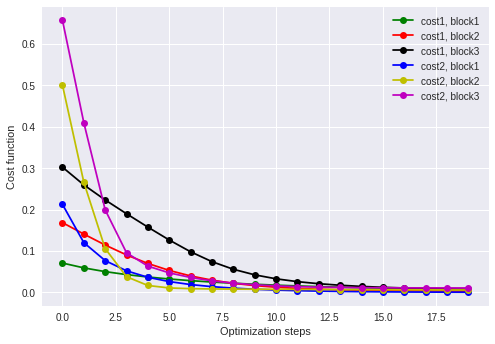

In [8]:
plt.style.use("seaborn")
plt.plot(data[0], "-og", label="cost1, block1")
plt.plot(data[1], "-or", label="cost1, block2")
plt.plot(data[2], "-ok", label="cost1, block3")
plt.plot(data[3], "-ob", label="cost2, block1")
plt.plot(data[4], "-oy", label="cost2, block2")
plt.plot(data[5], "-om", label="cost2, block3")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

# Results
From the above plots showing the variation for each hyperparameter-combination, we can roughly conclude that:
1) The global cost function (blue, yellow, magenta) results in a quicker solution. This results matches the paper's findings.
2) The first ansatz (green, blue) gives the lower initial cost. This may just be a case-specific thing.
3) The third ansatz (black, magenta) incorporates entanglement as part of the variational block, a usually preferred thing, and can be seen to be trained faster i.e. (black > red, green),  (magenta > yellow, blue).

## References
1) https://arxiv.org/pdf/1909.05820.pdf
2) https://pennylane.ai/qml/demos/tutorial_vqls.html
3) https://arxiv.org/pdf/2206.09992.pdf
4) https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)
